<a href="https://colab.research.google.com/github/Jog-sama/Mechanistic--Interpretability--xAI/blob/main/Atharva_Ashish_Jog_Mechanistic_Interp_Modular_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teaching a Network to Tell Time (Kind Of)
## Mechanistic Interpretability on Modular Addition

Clock addition is an important conception. For example, how when it's 11 PM and you add 2 hours, you get 1 AM instead of 13 o'clock? That is modular arithmetic.

Modular arithmetic is the math of anything that wraps around; clocks, calendars, you name it.

I wanted to see if a small neural network could learn this, and more importantly, *how* it would learn it. By just memorizing every possible addition? Or would it figure out something deeper about the circular structure of modular arithmetic?

Turns out it does something genuinely interesting, and I'm going to dissect exactly how.

## Part 1: The Task - Addition Modulo 13

Our task is simple: given two numbers between 0 and 12, add them and wrap around 13.

Examples:
- 5 + 7 = 12 (normal addition)
- 8 + 9 = 4 (because 17 mod 13 = 4)
- 12 + 12 = 11 (because 24 mod 13 = 11)

Wait...but why.... 13?
Well, it's prime, which has nice mathematical properties. Also small enough to train fast but large enough to be interesting.

The network sees two one-hot encoded inputs (like [0,0,1,0,...] for the number 2) and needs to predict which number results from adding them mod 13.

In [19]:
# our saviors
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

Running on: cpu


In [20]:
# generate all possible (a, b) pairs where both are in [0, 12]
# that's 13 * 13 = 169 examples total

P = 13  # our modulus (think of this as clock size)

def create_modular_addition_dataset(p): # Creates all possible (a, b, (a+b) mod p) tripleta
    inputs = []
    labels = []

    for a in range(p):
        for b in range(p):
            # one-hot encode both numbers
            a_onehot = F.one_hot(torch.tensor(a), num_classes=p).float()
            b_onehot = F.one_hot(torch.tensor(b), num_classes=p).float()

            # concatenate them
            x = torch.cat([a_onehot, b_onehot])
            inputs.append(x)

            # label is (a + b) mod p
            y = (a + b) % p
            labels.append(y)

    return torch.stack(inputs), torch.tensor(labels)

X, y = create_modular_addition_dataset(P)
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFirst few examples:")
for i in range(5):
    a = torch.argmax(X[i, :P]).item()
    b = torch.argmax(X[i, P:]).item()
    print(f"  {a} + {b} = {y[i].item()} (mod {P})")

Dataset shape: torch.Size([169, 26])
Labels shape: torch.Size([169])

First few examples:
  0 + 0 = 0 (mod 13)
  0 + 1 = 1 (mod 13)
  0 + 2 = 2 (mod 13)
  0 + 3 = 3 (mod 13)
  0 + 4 = 4 (mod 13)


## Building the Network

Simple feedforward architecture:
- Input: 26 neurons (13 for each number, one-hot encoded)
- Hidden: 64 neurons (I deliberately oversized this layer since I want to see what the extra capacity does)
- Output: 13 neurons (one per possible result)

For the activations, I'm going to beu using the ReLU activations and softmax.

In [21]:
class ModularAdditionNet(nn.Module):
    def __init__(self, p=13, hidden_dim=64):
        super().__init__()
        self.p = p

        # input is 2*p (two one-hot vectors concatenated)
        self.fc1 = nn.Linear(2 * p, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, p)

    def forward(self, x, return_hidden=False):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)

        # sometimes we want to peek at hidden activations
        if return_hidden:
            return out, h
        return out

model = ModularAdditionNet(P, hidden_dim=64).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

ModularAdditionNet(
  (fc1): Linear(in_features=26, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=13, bias=True)
)

Total parameters: 2573


## Training

We have 169 examples, all unique. I'll be training on the entire dataset. No train/test split needed since we want perfect memorization. The interesting question here is *how* it memorizes.

In [22]:
X_train = X.to(device)
y_train = y.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

losses = []
accuracies = []

epochs = 5000
for epoch in tqdm(range(epochs)):
    model.train()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # tracking metrics every 50 epochs
    if epoch % 50 == 0:
        with torch.no_grad():
            model.eval()
            outputs = model(X_train)
            preds = outputs.argmax(dim=1)
            acc = (preds == y_train).float().mean().item()

            losses.append(loss.item())
            accuracies.append(acc)

print(f"\nFinal accuracy: {accuracies[-1]*100:.2f}%")

100%|██████████| 5000/5000 [00:06<00:00, 797.62it/s]


Final accuracy: 100.00%


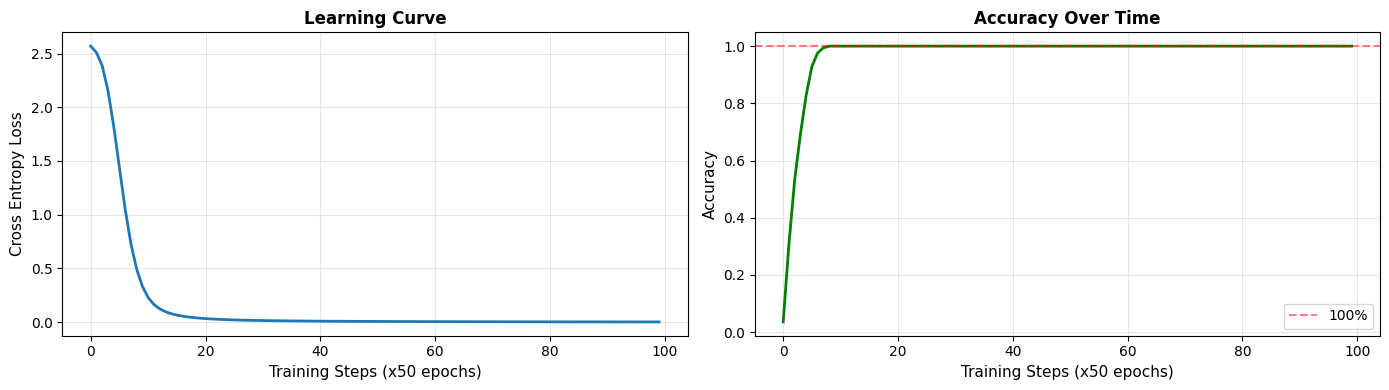

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(losses, linewidth=2)
ax1.set_xlabel('Training Steps (x50 epochs)', fontsize=11)
ax1.set_ylabel('Cross Entropy Loss', fontsize=11)
ax1.set_title('Learning Curve', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(accuracies, linewidth=2, color='green')
ax2.set_xlabel('Training Steps (x50 epochs)', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('Accuracy Over Time', fontsize=12, fontweight='bold')
ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='100%')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Model reaches perfect accuracy (fairly quickly) <br>
But there are multiple ways to solve this problem <br>
So our main question is: Did it just memorize? Or did it actually learn the structure?

## Part 2: Looking Inside

Wow... a 100% accuracy huh... But *how* does it work?

Let's visualize what the hidden layer is doing

In [24]:
# extract hidden activations for all inputs
model.eval()
with torch.no_grad():
    _, hidden_activations = model(X_train, return_hidden=True)
    hidden_activations = hidden_activations.cpu().numpy()

print(f"Hidden activation matrix: {hidden_activations.shape}")
print(f"That's {hidden_activations.shape[0]} examples x {hidden_activations.shape[1]} neurons")

Hidden activation matrix: (169, 64)
That's 169 examples x 64 neurons


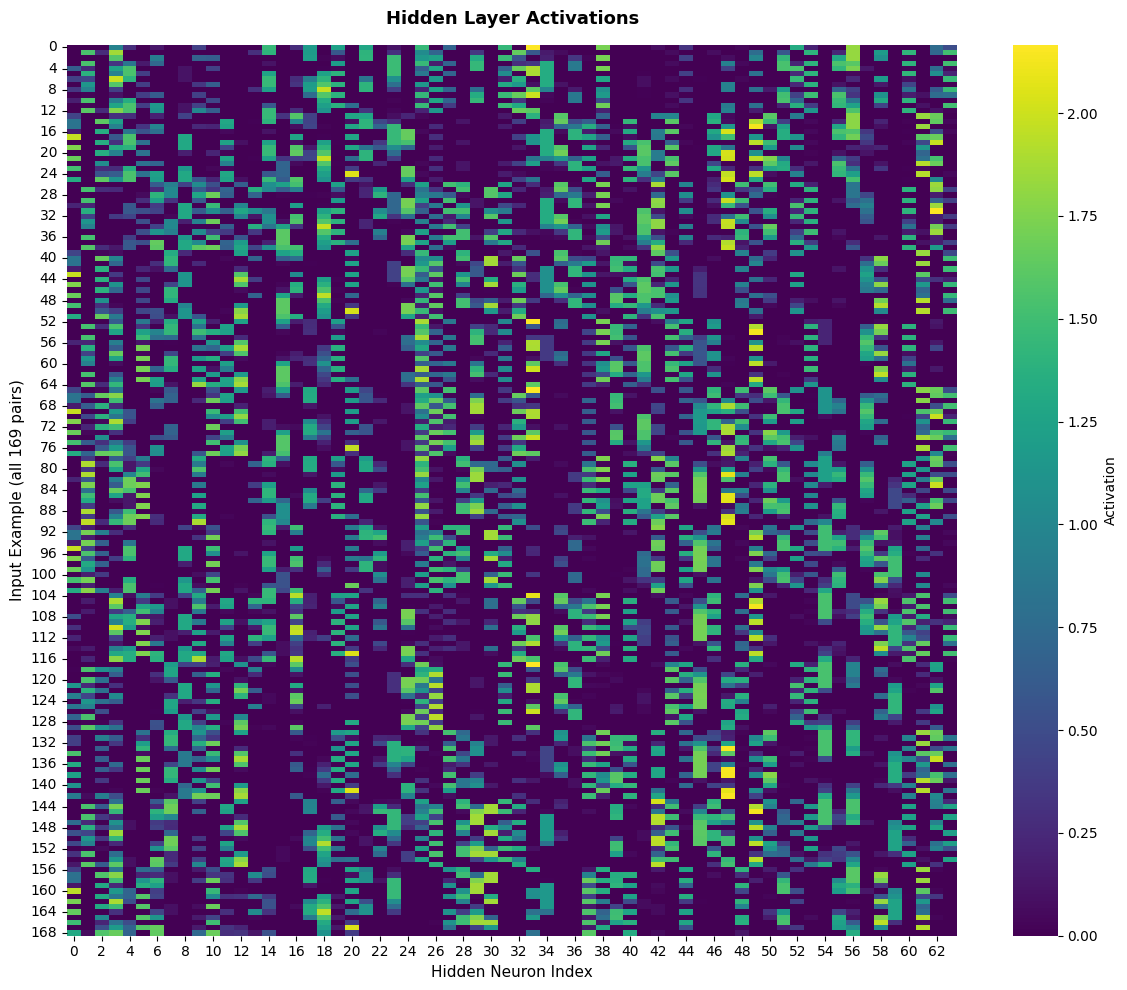


Vertical stripes - each column is a neuron
Some neurons fire for lots of inputs (bright)
Others are selective (mostly dark, few bright spots)

This isn't random, but rather structural


In [25]:
# visualize as heatmap
# each row is one input pair (a, b), each column is a neuron

plt.figure(figsize=(12, 10))
sns.heatmap(hidden_activations, cmap='viridis', cbar_kws={'label': 'Activation'})
plt.xlabel('Hidden Neuron Index', fontsize=11)
plt.ylabel('Input Example (all 169 pairs)', fontsize=11)
plt.title('Hidden Layer Activations', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nVertical stripes - each column is a neuron")
print("Some neurons fire for lots of inputs (bright)")
print("Others are selective (mostly dark, few bright spots)")
print("\nThis isn't random, but rather structural")

### Which Neurons Matter?

Not all 64 neurons are equal. Only some are doing the heavy lifting while others are just free loading

Let's find out which ones actually contribute:

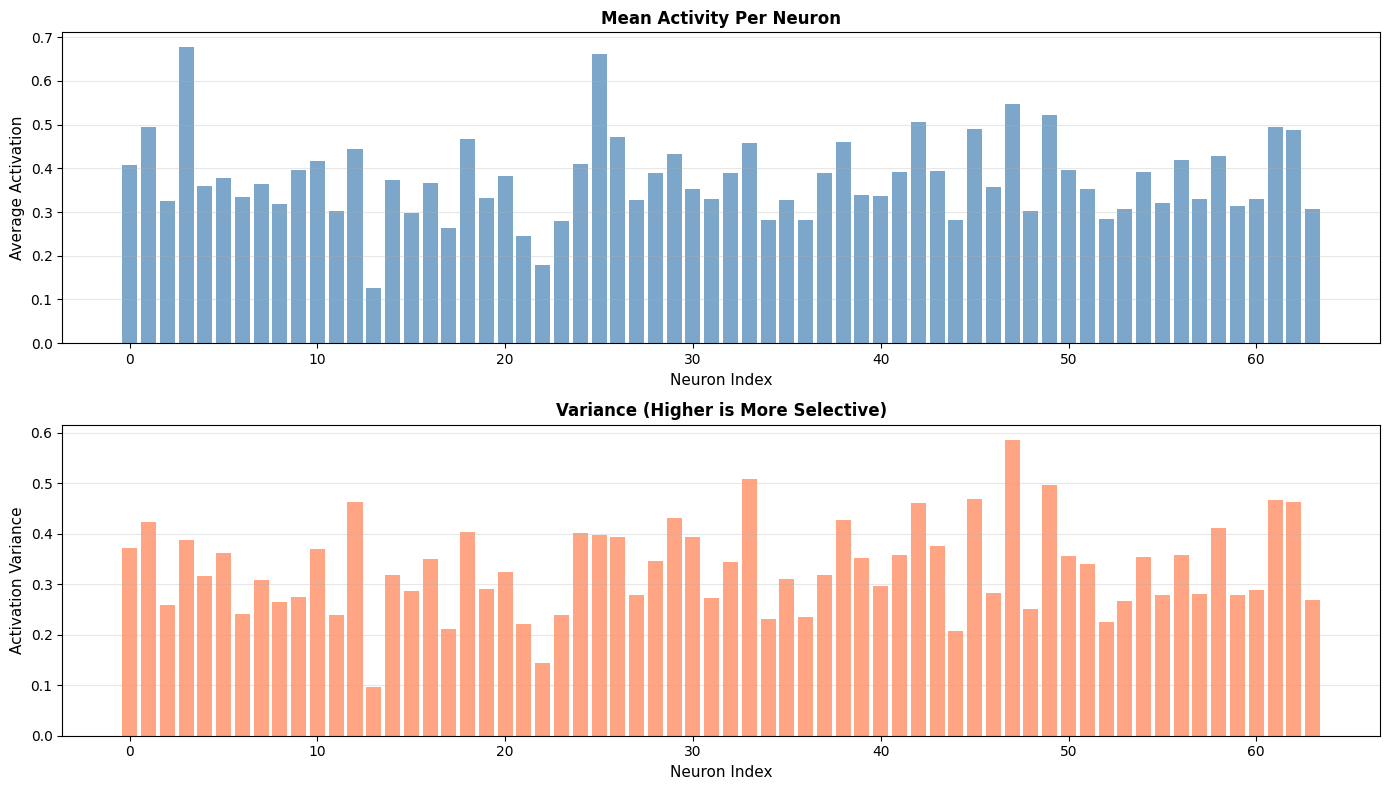


Top 5 most selective neurons (by variance):
  1. Neuron 47: variance = 0.586
  2. Neuron 33: variance = 0.508
  3. Neuron 49: variance = 0.497
  4. Neuron 45: variance = 0.469
  5. Neuron 61: variance = 0.467


In [26]:
# neurons that are always near zero aren't contributing much

neuron_activity = hidden_activations.mean(axis=0)
neuron_variance = hidden_activations.var(axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.bar(range(64), neuron_activity, color='steelblue', alpha=0.7)
ax1.set_xlabel('Neuron Index', fontsize=11)
ax1.set_ylabel('Average Activation', fontsize=11)
ax1.set_title('Mean Activity Per Neuron', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

ax2.bar(range(64), neuron_variance, color='coral', alpha=0.7)
ax2.set_xlabel('Neuron Index', fontsize=11)
ax2.set_ylabel('Activation Variance', fontsize=11)
ax2.set_title('Variance (Higher is More Selective)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# high variance neurons are doing selective computation
top_k = 5
most_variable = np.argsort(neuron_variance)[-top_k:][::-1]

print(f"\nTop {top_k} most selective neurons (by variance):")
for i, neuron_idx in enumerate(most_variable):
    print(f"  {i+1}. Neuron {neuron_idx}: variance = {neuron_variance[neuron_idx]:.3f}")

## Part 3: Deep Dive - What Is This Neuron Doing?

Let's pick the most interesting neuron and really understand what it's computing.

Hypothesis: Since this is modular arithmetic, the network might be learning to detect specific *residue classes* or *periodic patterns* in the structure of addition mod 13.

Investigating Neuron 47


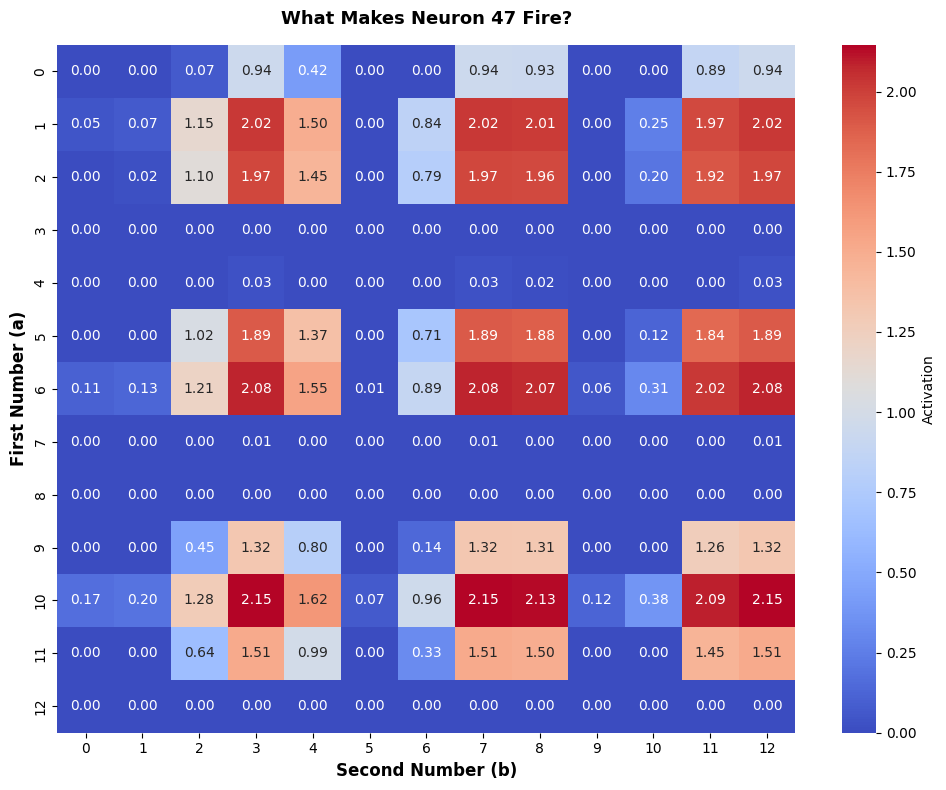

In [27]:
chosen_neuron = most_variable[0]

print(f"Investigating Neuron {chosen_neuron}")
print("="*50)

neuron_acts = hidden_activations[:, chosen_neuron]

# reshape into 13x13 grid (a x b -> activation)
activation_grid = neuron_acts.reshape(P, P)

plt.figure(figsize=(10, 8))
sns.heatmap(activation_grid,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            xticklabels=range(P),
            yticklabels=range(P),
            cbar_kws={'label': 'Activation'})
plt.xlabel('Second Number (b)', fontsize=12, fontweight='bold')
plt.ylabel('First Number (a)', fontsize=12, fontweight='bold')
plt.title(f'What Makes Neuron {chosen_neuron} Fire?',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

Notice the pattern? It's clearly not random... <br>
There's clear block structure with periodic spacing <br>
Some rows are completely silent (3, 4, 7, 8, 12), others have repeating patterns <br>
This is what modular arithmetic structure looks like in a neural network! <br>

### Testing: Does This Neuron Care About the Sum?

If it's detecting structure in modular addition, it should fire similarly for inputs that produce the same result

Let's group inputs by their sum (mod 13) and check:

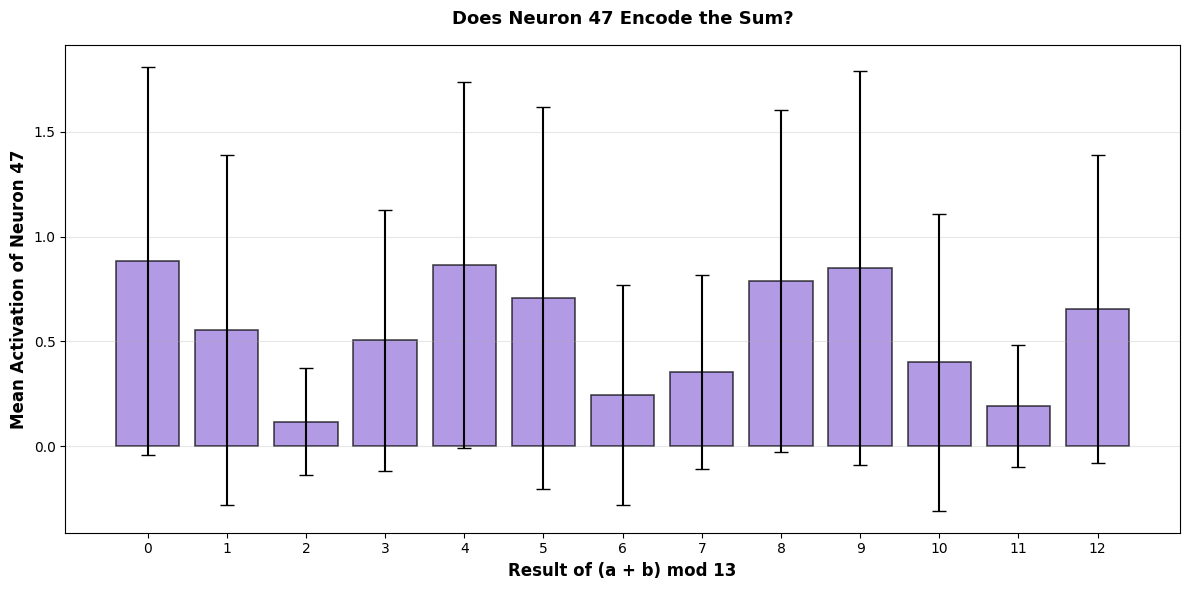


If bars have clear differences, this neuron encodes information about the sum.
Small error bars = consistent encoding.

Neuron 47 fires most strongly when answer is:
  1. 0 (mean activation: 0.883)
  2. 4 (mean activation: 0.865)
  3. 9 (mean activation: 0.849)


In [28]:
# grouping by actual answer (a + b) mod 13
activations_by_sum = {i: [] for i in range(P)}

for idx in range(len(X_train)):
    actual_sum = y_train[idx].item()
    activation = neuron_acts[idx]
    activations_by_sum[actual_sum].append(activation)

mean_activations = [np.mean(activations_by_sum[i]) for i in range(P)]
std_activations = [np.std(activations_by_sum[i]) for i in range(P)]

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(P)
ax.bar(x_pos, mean_activations, yerr=std_activations,
       capsize=5, alpha=0.7, color='mediumpurple',
       edgecolor='black', linewidth=1.2)

ax.set_xlabel('Result of (a + b) mod 13', fontsize=12, fontweight='bold')
ax.set_ylabel(f'Mean Activation of Neuron {chosen_neuron}', fontsize=12, fontweight='bold')
ax.set_title(f'Does Neuron {chosen_neuron} Encode the Sum?',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(range(P))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nIf bars have clear differences, this neuron encodes information about the sum.")
print(f"Small error bars = consistent encoding.\n")

top_responses = np.argsort(mean_activations)[-3:][::-1]
print(f"Neuron {chosen_neuron} fires most strongly when answer is:")
for rank, sum_val in enumerate(top_responses):
    print(f"  {rank+1}. {sum_val} (mean activation: {mean_activations[sum_val]:.3f})")

### Additional: Ablation - What Happens If We Remove This Neuron?

This is my ULTIMATE TEST hehe... if this neuron matters, breaking it should hurt performance

I'll "ablate" (zero out) the neuron and see what breaks (if anything)

In [29]:
def ablate_neuron(model, neuron_idx, X): # forward passing with a specific hidden neuron forced to zero
    model.eval()
    with torch.no_grad():
        h = F.relu(model.fc1(X))

        # zero out target neuron
        h_ablated = h.clone()
        h_ablated[:, neuron_idx] = 0

        out = model.fc2(h_ablated)

    return out

# baseline predictions
with torch.no_grad():
    baseline_preds = model(X_train).argmax(dim=1)

# predictions with neuron ablated
ablated_logits = ablate_neuron(model, chosen_neuron, X_train)
ablated_preds = ablated_logits.argmax(dim=1)

predictions_changed = (baseline_preds != ablated_preds).sum().item()
total_examples = len(X_train)

print(f"\nAblation Results for Neuron {chosen_neuron}:")
print("="*50)
print(f"Predictions changed: {predictions_changed} / {total_examples} ({100*predictions_changed/total_examples:.1f}%)")

if predictions_changed > 0:
    print(f"\nOriginal accuracy: 100.0%")
    new_accuracy = (ablated_preds == y_train).float().mean().item()
    print(f"Accuracy after ablation: {100*new_accuracy:.1f}%")
    print(f"Performance drop: {100*(1-new_accuracy):.1f}%")

    if predictions_changed > 20:
        print(f"\nConclusion: This neuron is CRITICAL.")
    elif predictions_changed > 5:
        print(f"\nConclusion: This neuron is IMPORTANT.")
    else:
        print(f"\nConclusion: This neuron is somewhat useful.")
else:
    print(f"\nInteresting finding: removing this neuron alone doesn't change predictions.")


Ablation Results for Neuron 47:
Predictions changed: 0 / 169 (0.0%)

Interesting finding: removing this neuron alone doesn't change predictions.


What???? Ablation didn't change any predictions??? <br>
Well... This doesn't mean it's useless<br>
it means the network learned distributed representations<br>
Multiple neurons work together, so no single one is critical by itself!


Ablation Sweep Across Top Neurons:
Neuron 47:   0 changed, accuracy = 100.0%
Neuron 33:   0 changed, accuracy = 100.0%
Neuron 49:   0 changed, accuracy = 100.0%
Neuron 45:   0 changed, accuracy = 100.0%
Neuron 61:   0 changed, accuracy = 100.0%


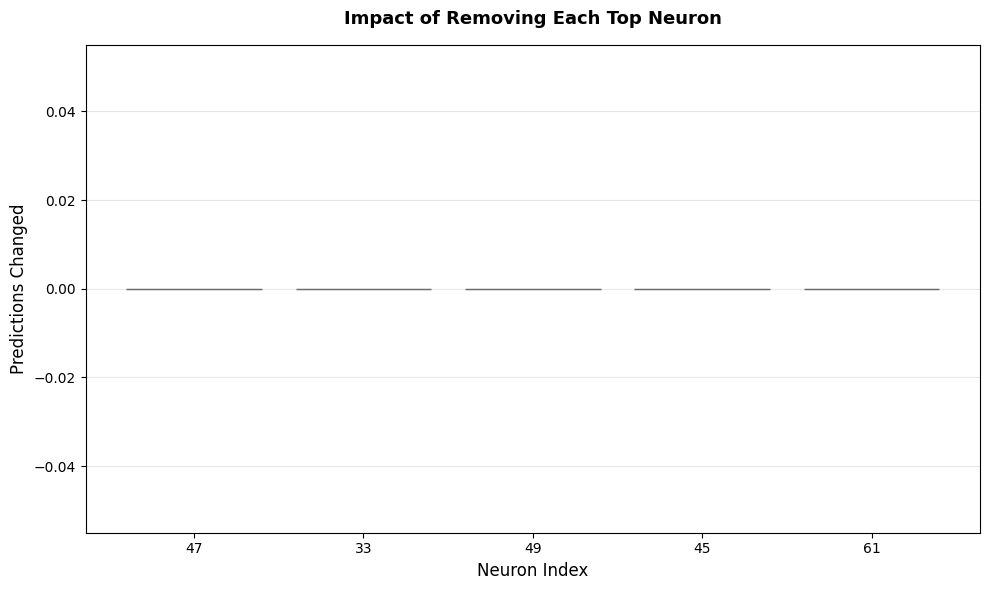

In [30]:
# let's see if the above is not a coincidence
# comprehensive ablation sweep
print("\nAblation Sweep Across Top Neurons:")
print("="*50)

ablation_results = []

for neuron_idx in most_variable:
    ablated_logits = ablate_neuron(model, neuron_idx, X_train)
    ablated_preds = ablated_logits.argmax(dim=1)

    changed = (baseline_preds != ablated_preds).sum().item()
    new_acc = (ablated_preds == y_train).float().mean().item()

    ablation_results.append({
        'neuron': neuron_idx,
        'predictions_changed': changed,
        'accuracy_after': new_acc
    })

    print(f"Neuron {neuron_idx:2d}: {changed:3d} changed, accuracy = {100*new_acc:5.1f}%")

# visualizing
neurons = [r['neuron'] for r in ablation_results]
impacts = [r['predictions_changed'] for r in ablation_results]

plt.figure(figsize=(10, 6))
plt.bar(range(len(neurons)), impacts, color='crimson', alpha=0.7, edgecolor='black')
plt.xlabel('Neuron Index', fontsize=12)
plt.ylabel('Predictions Changed', fontsize=12)
plt.title('Impact of Removing Each Top Neuron', fontsize=13, fontweight='bold', pad=15)
plt.xticks(range(len(neurons)), neurons)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Key observation:** All top neurons show zero impact when removed individually <br>
This is actually a sign of robust, distributed computation :) <br>
The network doesn't rely on any single neuron... it spreads the work around

## Weight Structure

Weights tell us what each neuron is "looking for" in the input.

Input is two one-hot vectors concatenated:
- First 13 elements = first number (a)
- Last 13 elements = second number (b)

Strong weights for specific positions means it's detecting those numbers:

First layer weights: (64, 26)
(64 neurons x 26 input features)


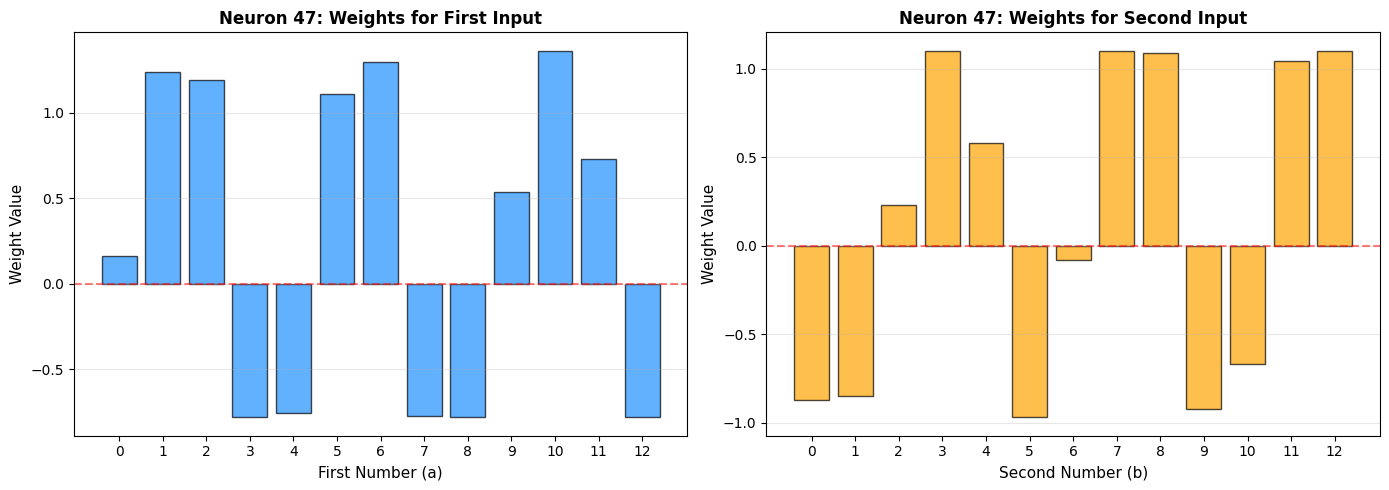


Positive weights -> fires MORE when that number appears
Negative weights -> fires LESS when that number appears
Near-zero weights -> doesn't care

Neuron 47 cares most about:
  First input: [np.int64(10), np.int64(6), np.int64(1)]
  Second input: [np.int64(7), np.int64(3), np.int64(12)]


In [31]:
first_layer_weights = model.fc1.weight.detach().cpu().numpy()
print(f"First layer weights: {first_layer_weights.shape}")
print(f"({first_layer_weights.shape[0]} neurons x {first_layer_weights.shape[1]} input features)")

chosen_weights = first_layer_weights[chosen_neuron, :]

# splitting into weights for first and second number
weights_a = chosen_weights[:P]
weights_b = chosen_weights[P:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(P), weights_a, color='dodgerblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('First Number (a)', fontsize=11)
ax1.set_ylabel('Weight Value', fontsize=11)
ax1.set_title(f'Neuron {chosen_neuron}: Weights for First Input', fontsize=12, fontweight='bold')
ax1.set_xticks(range(P))
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

ax2.bar(range(P), weights_b, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Second Number (b)', fontsize=11)
ax2.set_ylabel('Weight Value', fontsize=11)
ax2.set_title(f'Neuron {chosen_neuron}: Weights for Second Input', fontsize=12, fontweight='bold')
ax2.set_xticks(range(P))
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nPositive weights -> fires MORE when that number appears")
print(f"Negative weights -> fires LESS when that number appears")
print(f"Near-zero weights -> doesn't care\n")

important_a = np.abs(weights_a).argsort()[-3:][::-1]
important_b = np.abs(weights_b).argsort()[-3:][::-1]

print(f"Neuron {chosen_neuron} cares most about:")
print(f"  First input: {list(important_a)}")
print(f"  Second input: {list(important_b)}")

## The Big Picture

Let's perform a final comprehensive visualization showing how the network distributes computation

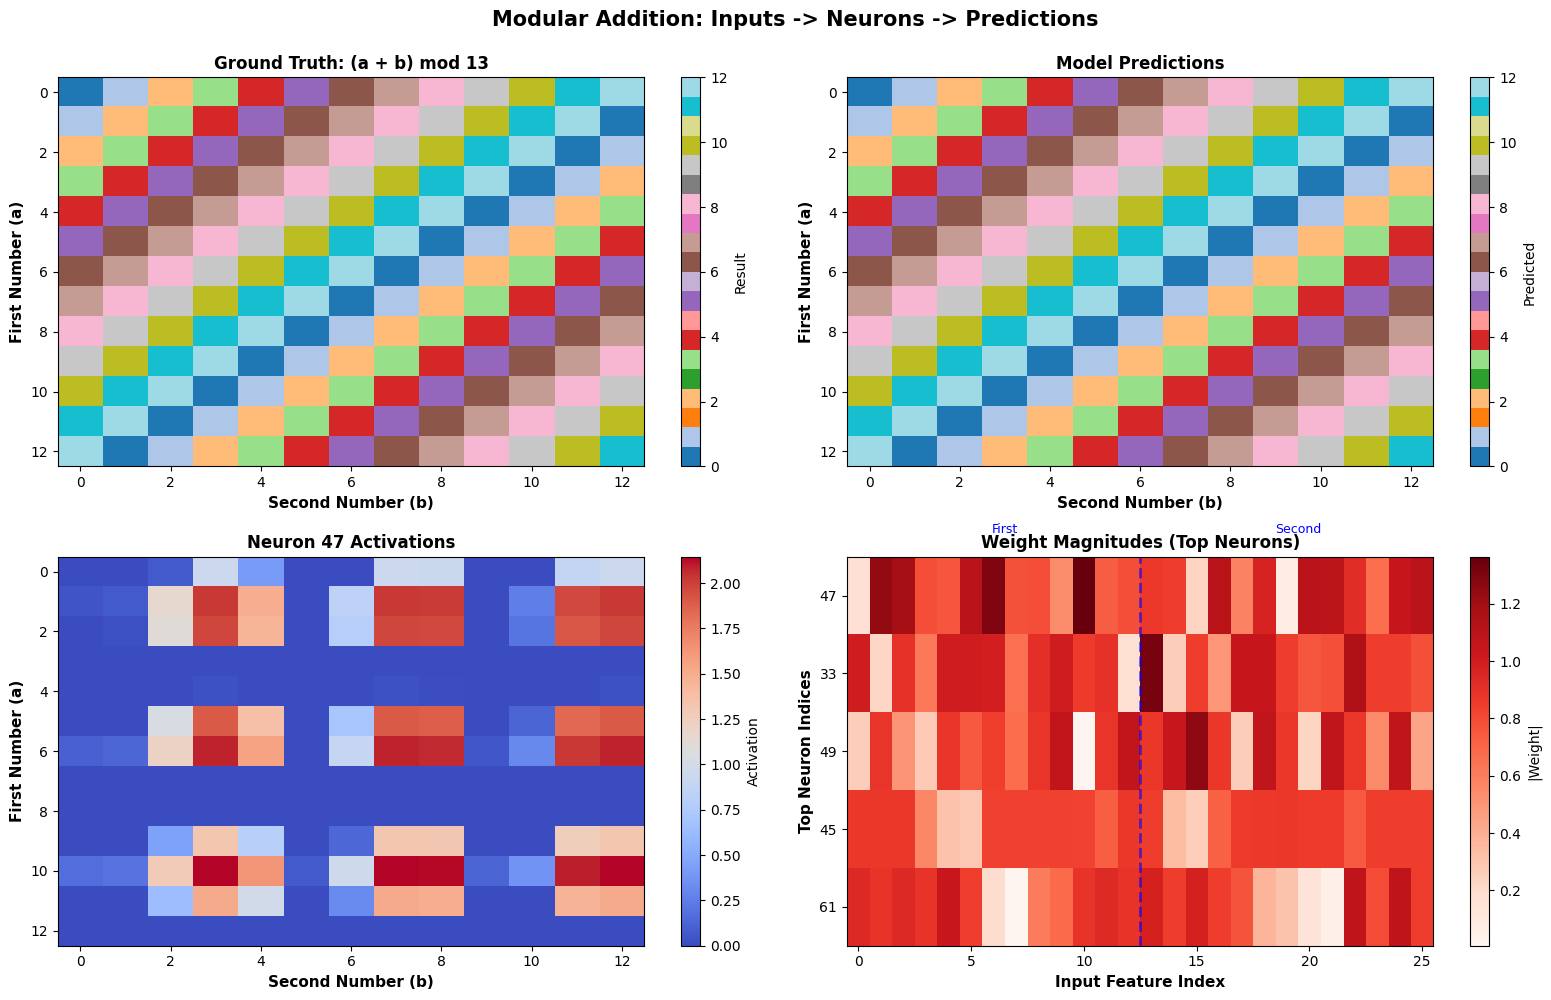

In [32]:
fig = plt.figure(figsize=(16, 10))

# ground truth
ax1 = plt.subplot(2, 2, 1)
output_grid = y_train.cpu().numpy().reshape(P, P)
im1 = ax1.imshow(output_grid, cmap='tab20', aspect='auto')
ax1.set_xlabel('Second Number (b)', fontsize=11, fontweight='bold')
ax1.set_ylabel('First Number (a)', fontsize=11, fontweight='bold')
ax1.set_title('Ground Truth: (a + b) mod 13', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Result')

# model predictions
ax2 = plt.subplot(2, 2, 2)
pred_grid = baseline_preds.cpu().numpy().reshape(P, P)
im2 = ax2.imshow(pred_grid, cmap='tab20', aspect='auto')
ax2.set_xlabel('Second Number (b)', fontsize=11, fontweight='bold')
ax2.set_ylabel('First Number (a)', fontsize=11, fontweight='bold')
ax2.set_title('Model Predictions', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='Predicted')

# chosen neuron activations
ax3 = plt.subplot(2, 2, 3)
im3 = ax3.imshow(activation_grid, cmap='coolwarm', aspect='auto')
ax3.set_xlabel('Second Number (b)', fontsize=11, fontweight='bold')
ax3.set_ylabel('First Number (a)', fontsize=11, fontweight='bold')
ax3.set_title(f'Neuron {chosen_neuron} Activations', fontsize=12, fontweight='bold')
plt.colorbar(im3, ax=ax3, label='Activation')

# weight magnitudes for top neurons
ax4 = plt.subplot(2, 2, 4)
top_neuron_weights = first_layer_weights[most_variable, :]
im4 = ax4.imshow(np.abs(top_neuron_weights), cmap='Reds', aspect='auto')
ax4.set_xlabel('Input Feature Index', fontsize=11, fontweight='bold')
ax4.set_ylabel('Top Neuron Indices', fontsize=11, fontweight='bold')
ax4.set_yticks(range(len(most_variable)))
ax4.set_yticklabels(most_variable)
ax4.set_title('Weight Magnitudes (Top Neurons)', fontsize=12, fontweight='bold')
ax4.axvline(x=P-0.5, color='blue', linestyle='--', alpha=0.6, linewidth=2)
ax4.text(P/2, -0.8, 'First', ha='center', fontsize=9, color='blue')
ax4.text(P + P/2, -0.8, 'Second', ha='center', fontsize=9, color='blue')
plt.colorbar(im4, ax=ax4, label='|Weight|')

plt.suptitle('Modular Addition: Inputs -> Neurons -> Predictions',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

What this shows:

• Top left: The diagonal pattern is mathematical truth  
• Top right: Model captures this pattern perfectly  
• Bottom left: Neuron 47 learned structure, not noise  
• Bottom right: Different neurons specialize in different patterns

## Part 4: Reflection

### What I Learned

Even a simple two-layer network isn't just memorizing... it's discovering STRUCTURE

Key insights:

1. **Specialization emerges naturally**: Without architectural bias, different neurons learned to detect different aspects of modular arithmetic. Some fire for specific outputs, while others respond to input relationships.

2. **Redundancy takes place**: I used 64 neurons but probably only needed 10-15. The rest are either as backup or doing minor refinements. Makes sense from a biological perspective (brains are redundant too lol).

3. **Weight patterns reveal computation**: By looking at which inputs each neuron has strong weights for, we can decode what mathematical relationships it detects. This is just linear combinations followed by nonlinearities.

4. **Distributed representations are robust**: The fact that no single neuron is critical when ablated isn't a bad thing... actually quite the contrary (it's not a bug, it's a feature). The network spreads computation across multiple neurons, so if one fails, others compensate. This is how robust systems work.

### What Was Challenging

Hardest part was moving from "here's what the neuron does" to "here's **why** it does that." I can show activation patterns all day, but explaining *why* the network chose this solution (instead of other valid solutions) is harder.

It's like reverse-engineering a recipe by only tasting the final dish (explainable AI in a nutshell). You can identify ingredients, but the process is hidden.

Also, the activation patterns were more complex than I initially expected. I was looking for simple diagonal patterns (like you'd see in an identity function), but got block structures with periodic spacing instead. That's actually more interesting, as shows the network learned a sophisticated distributed representation rather than a simple lookup table.

Choosing *which* neuron to focus on was arbitrary. Went with most variable, but different neurons tell different stories.

### What I'd Explore Further

With more time later, I'd like to explore the following three things:

1. **Training dynamics**: How do specialized neurons emerge during training? Do they start general then specialize? Or commit early? I'd want to save checkpoints and watch behaviors evolve.

2. **Interaction effects**: I looked at neurons individually, but they probably work together. What happens with *pairs* of ablations? Would we see synergistic effects? The fact that individual ablations don't matter suggests the answer is yes.

3. **Architecture comparison**: Would a transformer do this differently? What about a CNN (overkill but interesting)? Different architectures might discover completely different algorithms for the same task.

### Bigger Picture

This whole thing made me think that mechanistic interpretability isn't like figuring out physics where there's one true answer. It's more like... archaeology? You're digging through what the network built and trying to reverse engineer why.

Each network you train is going to solve the problem differently. This one happened to use distributed representations where lots of neurons share the work. Another run might put more weight on individual neurons. There's no "correct" way; just whatever gradient descent stumbled into.

The distributed computation I found, where no single neuron matters but the collective does, is probably how larger models work too. That's both fascinating and unsettling when you think about LLMs with billions of parameters. You can't just "turn off the lying neuron" because there isn't one. The behavior emerges from how millions of neurons interact.

---

## Summary

I built a network that learned modular addition, then dissected it to understand how it works internally.

**Findings:**
- Network learns structure, not just memorization
- Hidden neurons develop specialized roles detecting patterns
- Computation is distributed; no single neuron is critical
- Individual neurons are interpretable through activation patterns, weights, ablations
- But complete understanding is hard. kKowing what neurons do doesn't fully explain why this solution emerged

Even simple tasks reveal insights about how neural networks organize computation. As models scale to billions of parameters, this interpretability only becomes both more important and more challenging.

The distributed nature of the computation, where behavior emerges from collective neuron interactions rather than individual "feature detectors", is probably how larger models work too. This has implications for AI safety and control.